# Combination of Hawkes Trade Flow & Propagator

by Zijie Gu

reference:

1. Bouchaud, Jean-Philippe, et al. Trades, quotes and prices: financial markets under the microscope. Cambridge University Press, 2018.
2. Gatheral, Jim, Thibault Jaisson, and Mathieu Rosenbaum. "Volatility is rough." Commodities. Chapman and Hall/CRC, 2022. 659-690.

## Hawkes Process

The trade order model is set up as 2 Hawkes processes representing buy trade order $N_+$ and sell trade order $N_-$ respectively, with intensities:
$$
\begin{align*}
    \lambda_+(t)&=\mu+\int_0^t\phi_+(t-s)N^+_s+\int_0^t\phi_-(t-s)N^-_s \\
    \lambda_+(t)&=\mu+\int_0^t\phi_-(t-s)N^+_s+\int_0^t\phi_+(t-s)N^-_s \\
\end{align*}
$$

The kernels are assumed to be:
$$
\phi_\pm(\tau)=\alpha_\pm(1+\tau/\tau_0)^{-\gamma-1},\alpha_+\ne\alpha_-,\gamma>0
$$

For this section, I first simulate the trade order model (since it operates independent of the propagator part) and verify a stylized fact: the long-range autocorrelation of the trade signs.

In [1]:
import numpy as np
import pandas as pd
from tick.hawkes import SimuHawkes, HawkesKernelPowerLaw
import matplotlib.pyplot as plt
from tick.plot import plot_point_process

alpha_p = 0.15
alpha_m = 0.08
T=100000.0
mu=0.05
gamma=0.5
tau0=1.0

baseline = [mu, mu]

phi_p = HawkesKernelPowerLaw(alpha_p*tau0**(gamma+1.0), tau0, gamma+1.0)
phi_m = HawkesKernelPowerLaw(alpha_m*tau0**(gamma+1.0), tau0, gamma+1.0)

kernels = [
    [phi_p, phi_m],
    [phi_m, phi_p]
]

hawkes = SimuHawkes(kernels=kernels, baseline=baseline, end_time=T, seed=42)
hawkes.simulate()
timestamps = hawkes.timestamps

df_p = pd.DataFrame(np.array([timestamps[0], [+1] * timestamps[0].shape[0]]).T, columns=["time", "sign"])
df_m = pd.DataFrame(np.array([timestamps[1], [-1] * timestamps[1].shape[0]]).T, columns=["time", "sign"])
df = pd.concat([df_p, df_m]).sort_values("time").reset_index(drop=True)
df

----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 5.43e+00 seconds.


,time,sign
0,14.071321,-1.0
1,18.298328,1.0
2,24.986504,1.0
3,27.453886,-1.0
4,28.302899,-1.0
...,...,...
18592,99930.681707,-1.0
18593,99960.983543,1.0
18594,99962.230120,1.0
18595,99971.818239,1.0


After simulation, I plot the order sign autocorrelation in event-time. It does have the feeling of a power law, but doesn"t fit very well.

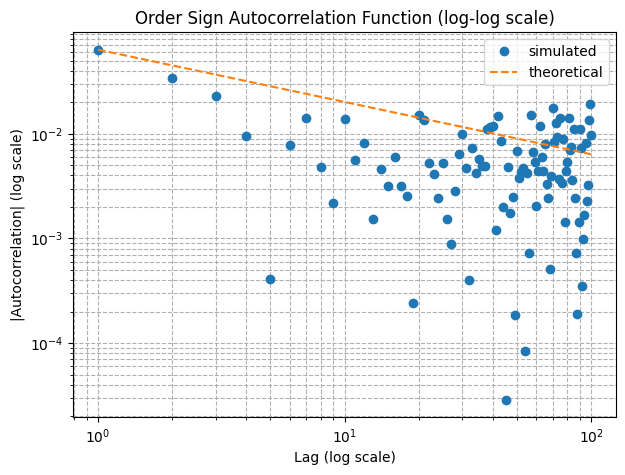

In [2]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

nlags = 100
acf_vals = acf(df["sign"], nlags=nlags, fft=True)
lags = np.arange(1, nlags + 1)
acf_vals = acf_vals[1:]

plt.figure(figsize=(7,5))
plt.loglog(lags, np.abs(acf_vals), marker="o", linestyle="none", label="simulated")
plt.loglog(lags, np.abs(acf_vals[0])*np.power(lags, -gamma), linestyle="--", label="theoretical")
plt.xlabel("Lag (log scale)")
plt.ylabel("|Autocorrelation| (log scale)")
plt.title("Order Sign Autocorrelation Function (log-log scale)")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

## Propagator

Since order sign exhibits long range autocorrelation while price return doesn"t exhibit autocorrelation, adding a propagator to the price impact part becomes necessary. I choose a power law propagator:
$$
G(\tau)=\eta(1+\tau/\tau_G)^{-\beta},\beta\in(0,0.5),\eta>0
$$

Here $\eta$ represents the instant impact magnitude.

For comparison, I also use the exponential propagator scenario where
$$
G(\tau)=\eta e^{-\beta\tau}
$$

and the no-propagator scenario (null scenario).

Then the mid price $p_t$ is generated by (ignoring the noise):
$$
p_t=p_0+\int_0^tG(t-s)(\mathrm{d}N^+_s-\mathrm{d}N^-_s)
$$

  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [00:57<00:00, 3474.18it/s]


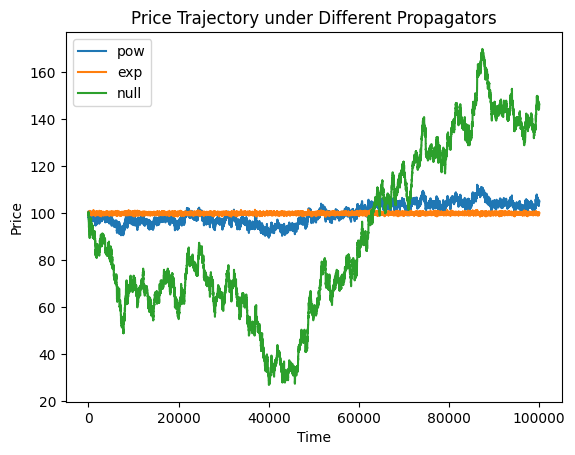

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# g should be friendly to vectorize in numpy
# events are of shape (n_events,2), first column is time, second column is sign
def form_price(g, T, dt, events, p0):
    grid = np.arange(0, T, dt)
    prices = np.zeros_like(grid, dtype=float)
    for i in tqdm(range(len(grid))):
        t = grid[i]
        selected = events[events[:, 0] <= t, :]
        prices[i] = p0 + np.dot(g(t-selected[:, 0]), selected[:, 1])
        
    return prices

def propagator_pow(tau, eta, tauG, beta):
    return eta*np.power(1.0+tau/tauG, -beta)

def propagator_exp(tau, eta, beta):
    return eta*np.exp(-beta*tau)

def propagator_null(_tau, eta):
    return eta*np.ones_like(_tau, dtype=float)


dt = 0.5
events = df.to_numpy()
price_df = pd.DataFrame({
    "time": np.arange(0, T, dt),
    "pow": form_price(lambda tau: propagator_pow(tau, 0.5, 1.0, 0.25), T, dt, events, 100.0),
    "exp": form_price(lambda tau: propagator_exp(tau, 0.5, 1.0), T, dt, events, 100.0),
    "null": form_price(lambda tau: propagator_null(tau, 0.5), T, dt, events, 100.0),
}).set_index("time")
price_df.plot(title="Price Trajectory under Different Propagators", xlabel="Time", ylabel="Price");

As shown by the plot, even with the same event series, the price trajectory generated through different propagator varies dramatically. The exponential propagator yields a price trajectory that simply oscillates around the initial value since each price impact fades too quickly. The case with no propagator yields a more volatile price trajectory since every trade permanently moves the mid price. The power law propagator case sits somewhere in-between.

Now I want to see the distribution of returns, to see what return distribution each propagator generates.

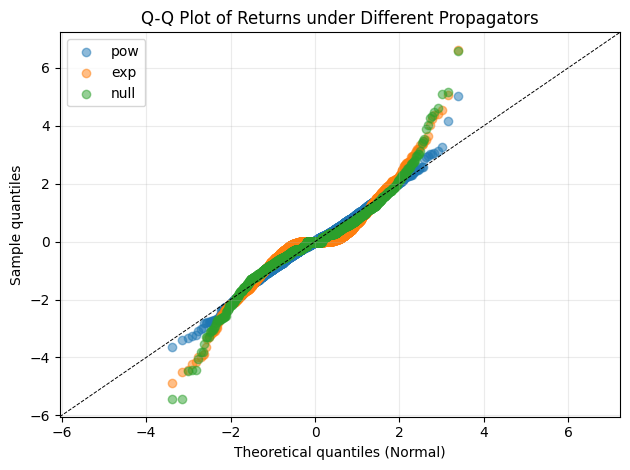

In [4]:
import matplotlib.pyplot as plt
from scipy import stats


returns_df = price_df.iloc[::100, :].pct_change().dropna()
plt.figure()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, col in enumerate(returns_df):
    x = returns_df[col].to_numpy()
    # standardize
    z = (x - x.mean()) / x.std(ddof=1)
    theo_q, _ = stats.probplot(z, dist="norm", fit=False)
    samp_q = np.sort(z)
    plt.scatter(theo_q, samp_q, color=colors[i % len(colors)], label=col, alpha=0.5)

# 45-degree reference line
mn = plt.gca().get_xlim()
mx = plt.gca().get_ylim()
lo = min(mn[0], mx[0])
hi = max(mn[1], mx[1])
plt.plot([lo, hi], [lo, hi], color="k", linewidth=0.7, linestyle="--")
plt.xlim(lo, hi)
plt.ylim(lo, hi)

plt.xlabel("Theoretical quantiles (Normal)")
plt.ylabel("Sample quantiles")
plt.title("Q-Q Plot of Returns under Different Propagators")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

It is clear that in all 3 cases heavy-tailed return is shown, although for the exponential propagator there is also some deviation in the middle.

Now let's try to study the volatility behavior. To do that, I first need to compute the realized volatility.

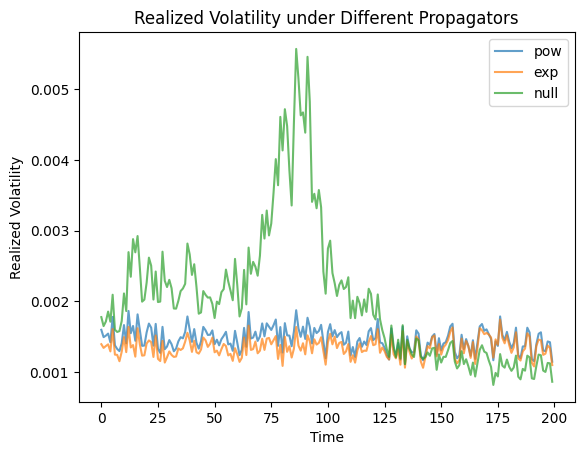

In [5]:
volatility_df = price_df.pct_change().dropna().groupby(np.arange(len(price_df)-1) // 1000).std(ddof=1)
volatility_df.plot(title="Realized Volatility under Different Propagators", alpha=0.7, xlabel="Time", ylabel="Realized Volatility");

Here I try to determine whether the simulated realized volatility is rough. I use Gatheral's method because it's simple and easy to visualize.

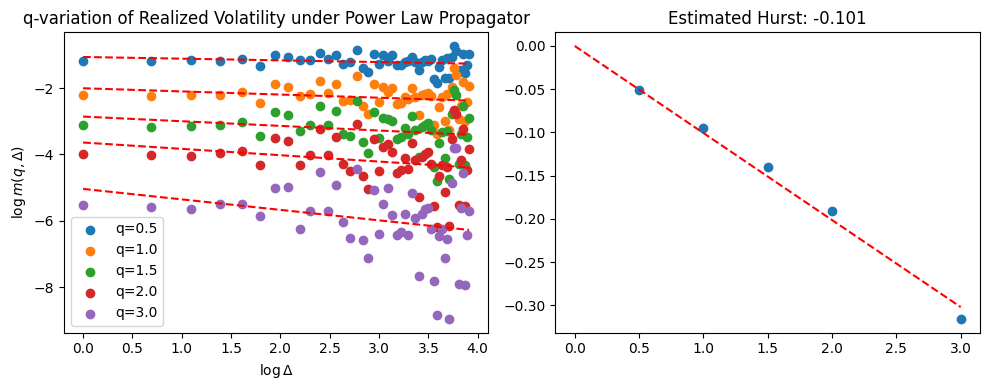

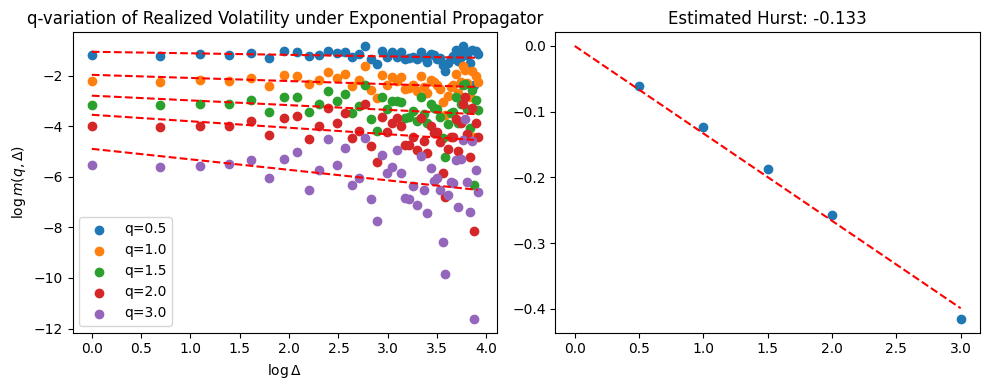

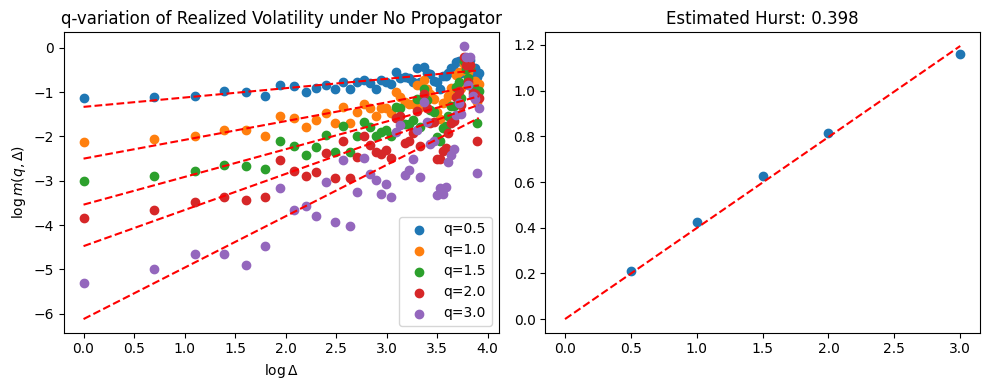

In [6]:
import matplotlib.pyplot as plt


def q_variation(log_vol: np.ndarray, q, delta):
    return np.mean(np.abs(np.diff(log_vol[::delta])) ** q)

qs = [0.5, 1.0, 1.5, 2.0, 3.0]
deltas = np.arange(1, 51, 1)
propagator_name = {
    "exp": "Exponential",
    "pow": "Power Law",
    "null": "No",
}
for col in volatility_df:
    m = np.zeros((len(qs), len(deltas)))
    for i, q in enumerate(qs):
        for j, delta in enumerate(deltas):
            m[i, j] = q_variation(np.log(volatility_df[col].to_numpy()), q, delta)
    slopes = np.zeros(len(qs))
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False)
    for i, q in enumerate(qs):
        axes[0].scatter(np.log(deltas), np.log(m[i, :]), label=f"q={q}")
        coeff = np.polyfit(np.log(deltas), np.log(m[i, :]), 1)
        slopes[i] = coeff[0]
        axes[0].plot(np.log(deltas), np.log(deltas) * coeff[0] + coeff[1], "--r")
    axes[0].set_xlabel(r"$\log\Delta$")
    axes[0].set_ylabel(r"$\log m(q,\Delta)$")
    axes[0].set_title(f"q-variation of Realized Volatility under {propagator_name[str(col)]} Propagator")
    axes[0].legend()
    hurst = np.dot(slopes, qs) / np.dot(qs, qs)
    axes[1].scatter(qs, slopes)
    axes[1].plot([0.0]+qs, hurst * np.array([0.0]+qs), "--r")
    axes[1].set_title(f"Estimated Hurst: {hurst:.3f}")
    fig.tight_layout()

Although I can see the somewhat clear linear relation between $\xi_q$ and $q$, $\log m(q,\Delta)$ and $\log\Delta$ doesn't show such a linear relation, which is presumably why the Hurst parameter estimated from the exponential and power law propagator is spurious. I assume this is caused by the terrible parameters I set for this simulation.

The next step should be calibrating the parameters using empirical data. But I feel that ignoring the order size won't work well with empirical trade data. Therefore I also decide to introduce order size to the original model:
$$
\begin{align*}
    \lambda_+(t)&=\mu+\int_0^t\int_0^\infty\phi_+(t-s,v)N^+(\mathrm{d}s,\mathrm{d}v)+\int_0^t\int_0^\infty\phi_-(t-s,v)N^-(\mathrm{d}s,\mathrm{d}v) \\
    \lambda_+(t)&=\mu+\int_0^t\int_0^\infty\phi_-(t-s,v)N^+(\mathrm{d}s,\mathrm{d}v)+\int_0^t\int_0^\infty\phi_+(t-s,v)N^-(\mathrm{d}s,\mathrm{d}v) \\
\end{align*}
$$

where
$$
\phi_\pm(\tau,v)=\alpha_\pm v^\kappa(1+\tau/\tau_0)^{-\gamma-1},\alpha_+\ne\alpha_-,\kappa\in(0,1),\gamma>0
$$

and the price is formed by
$$
p_t=p_0+\int_0^t\int_0^\infty v^\delta G(t-s)(N^+(\mathrm{d}s,\mathrm{d}v)-N^-(\mathrm{d}s,\mathrm{d}v)),\delta\in(0,1)
$$

and the distribution of $v$, denoted by $f(v)$ ought to be modeled from the empirical distribution.

This extended model is significantly harder to calibrate or to simulate efficiently, but I am eager to explore it more.